
<div style="align: center;">
    <br>
    <img src="https://media.licdn.com/dms/image/v2/D4D12AQFVzjRWeNpA7w/article-cover_image-shrink_720_1280/article-cover_image-shrink_720_1280/0/1711408967531?e=2147483647&v=beta&t=5MHJ_rGqMoarKpOy6DkK24xaJO01VPyj_piB96MxaLI" style="display:block; margin:auto; width:95%; height:250px;">
    <br>
    <h1 align = 'center'>Segmentación de una base de datos de clientes para ayudar al retailer a mejorar sus resultados desarrollando sus diferentes tipologías de clientes.</h1>
</div>
<div>
    <h3 id="INDICE">INDICE</h3>
    <ul>
        <li><a href="#Exploracion_de_los_datos">Exploración de los datos</a></li>
        <li><a href="#Constuccion_de_indicadores">Construcción de indicadores</a></li>
        <li><a href="#ELaboracion_Life_Time_Value">Elaboración de Live Time Value</a></li>
        <li><a href="#Extraccion_de_informacion_clave">Extracción de información clave</a></li>
    </ul>
</div>


<div>
    <h1 align = 'center' id="Exploracion_de_los_datos">Exploración de los datos</h1>
    <h3><a href="#INDICE">INDICE</a></h3>
</div>

In [2]:
import pandas as pd
# Subimos dos data frames
# Dataframe de ventas
df = pd.read_csv('VENTAS DE LOS CLIENTES DE LA MUESTRA.csv', delimiter='\t')
# Dataframe de tipologias de clientes
df_tipologias = pd.read_csv('TIPOLOGIAS Y ACTIVIDAD DEL CLIENTE.csv', delimiter='\t')

In [10]:
df.head(10)

,CUSTOMER ID,personid,Receipt_Number,Purchase_Date,Article_Number,Price_of_Article,Purchase_Quantity,Price_of_Article_euros,Purchase_Amount_euros
0,920080000720,360,49,2016-10-25,20218545,16.00,2.0,2.158242,4.316485
1,920080000720,360,49,2016-10-25,20264599,NaN,1.0,NaN,12.938663
2,920080000720,360,49,2016-10-25,60152444,NaN,2.0,NaN,8.611387
3,920080000720,360,191,2016-02-06,60233426,NaN,1.0,NaN,1.607891
4,920080000720,360,191,2016-02-06,60236104,NaN,1.0,NaN,2.687012
5,920080000720,360,191,2016-02-06,10218536,20.00,2.0,2.697803,5.395606
6,920080000720,360,69,2018-01-03,10219965,119.92,1.0,16.176026,16.176026
7,920080000720,360,223,2015-06-08,10280632,60.00,1.0,8.093409,8.093409
8,920080000720,360,223,2015-06-08,10287327,29.90,1.0,4.033215,4.033215
9,920080000720,360,69,2018-01-03,10324278,55.92,1.0,7.543057,7.543057


<div>
    <h1 id="Constuccion_de_indicadores">Construcción de indicadores</h1>
    <h4><a href="#INDICE">INDICE</a></h4>
</div>

In [4]:
# creamos una copia de los datos
df_datos = df.copy(deep=False)
# Cambiamos el formato de la fecha
df_datos['Purchase_Date'] = pd.to_datetime(df_datos['Purchase_Date'], format='%Y-%m-%d')
# Extraemos el año de la fecha
df_datos['Año'] = df_datos['Purchase_Date'].dt.year
# Convertimos la columna en formato date
df_datos['Purchase_Date'] = df_datos['Purchase_Date'].dt.date
# Calculamos el margen suponiendo que la ganacia es un 40%
df_datos['margen'] = df_datos['Purchase_Amount_euros']*0.40
# Calculamos el gross contribution(GC)
df_datos['GC'] = df_datos['Purchase_Amount_euros'] - df_datos['margen']
# Calculamos t
df_datos['t'] = df_datos['Año'].max()-df_datos['Año']
# PCV por fila
df_datos['PCV por fila'] = df_datos['GC'] * ((1/(1+0.1))**df_datos['t'])

<div>
    <h1 id = "ELaboracion_Life_Time_Value">Elaboración de Life Time Value</h1>
    <h4><a href="#INDICE">INDICE</a></h4>
</div>

<h3>Life Time Value</h3>
<img src="Life Time Value.png">
<p>Esta es la formula que utilizamos para el calculo final.</p>

In [5]:
pcv = df_datos.groupby('CUSTOMER ID').agg(pcv = ('PCV por fila','sum'),
                                    suma_compra =('Purchase_Amount_euros','sum'),
                                    suma_margen = ('margen','sum'),
                                    date_min = ('Purchase_Date', 'min'),
                                    date_max = ('Purchase_Date', 'max'),
                                    Receipt_count = ('Receipt_Number', 'nunique')).reset_index()
pcv['quintil_pcv'] = pd.qcut(pcv['pcv'], 5, labels=['pcv muy bajo', 'pcv bajo', 'pcv medio', 'pcv alto', 'pcv muy alto'])
pcv= pd.merge(pcv, df_tipologias, on='CUSTOMER ID')

<div>
    <h1 id = "Extraccion_de_informacion_clave">Extracción de información clave</h1>
    <h4><a href="#INDICE">INDICE</a></h4>
</div>

In [6]:
tabla_cruzada = pd.crosstab(pcv['quintil_pcv'], pcv['TIPOLOGIA DE CLIENTE'], margins=True)
tabla_cruzada

TIPOLOGIA DE CLIENTE,a,b,c,d,All
quintil_pcv,,,,,
pcv muy bajo,0,0,103,418,521
pcv bajo,0,71,241,209,521
pcv medio,3,247,262,9,521
pcv alto,53,452,16,0,521
pcv muy alto,340,180,1,0,521
All,396,950,623,636,2605


In [7]:
# Se comprueba si la tipologia del cliente y la clasificacion por quintiles tienen una relación significativa
import pandas as pd
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(tabla_cruzada)
print('el valor de chi cudrado es',chi2)
print('el valor de p es',p)
if p < 0.05:
    print("Existe una relación significativa entre las variables.")
else:
    print("No existe una relación significativa entre las variables.")

el valor de chi cudrado es 3305.537742883493
el valor de p es 0.0
Existe una relación significativa entre las variables.


##### Esto indica que a medida que aumenta la fidelización del cliente su aporte para la empresa también se incrementa

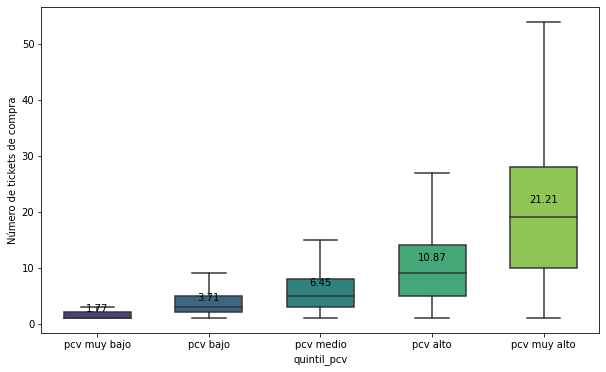

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Quintiles de acuerdo al numero de tickets de compra (Receipt_count)
medias = pcv.groupby('quintil_pcv')['Receipt_count'].mean()
plt.figure(figsize=(10, 6))
sns.boxplot(x='quintil_pcv', y='Receipt_count', data=pcv, palette="viridis", 
            width=0.6, showfliers=False, color='red')
for i in range(len(medias)):
    plt.plot([i, i], [medias[i], medias[i]], color='black', linestyle='--')
for i, mean in enumerate(medias):
    plt.text(i, mean, f'{mean:.2f}', ha='center', va='bottom')
plt.ylabel('Número de tickets de compra')
plt.savefig('D:\Proyectos\HTML\proyecto2\img\p5.png', bbox_inches='tight')
plt.show()

##### En la gráfica se observa que el quintil más alto tiene una media de compras mayor

In [13]:
pcv.columns

Index(['CUSTOMER ID', 'pcv', 'suma_compra', 'suma_margen', 'date_max',
       'date_min', 'Receipt_count', 'quintil_pcv', 'TIPOLOGIA DE CLIENTE',
       'ACTIVIDAD'],
      dtype='object')

In [17]:
pcv.sort_values('suma_compra', ascending=False).head(20)

,CUSTOMER ID,pcv,suma_compra,suma_margen,date_max,date_min,Receipt_count,quintil_pcv,TIPOLOGIA DE CLIENTE,ACTIVIDAD
2300,934000504894,8638.509597,16796.203924,6718.481570,2018-12-30,2016-04-26,50,pcv muy alto,a,ACTIVE
2388,934002652962,8103.161493,15029.675845,6011.870338,2018-12-02,2017-06-30,8,pcv muy alto,a,ACTIVE
11,920080008142,6115.920078,14743.333738,5897.333495,2018-11-13,2014-09-20,39,pcv muy alto,a,ACTIVE
1018,928010251712,7038.334342,14637.917080,5855.166832,2019-01-19,2014-11-26,48,pcv muy alto,a,ACTIVE
602,920092457218,6419.583124,13636.220173,5454.488069,2018-12-08,2015-12-29,46,pcv muy alto,a,ACTIVE
210,920084093398,5318.552943,12479.874384,4991.949754,2019-01-12,2014-11-05,43,pcv muy alto,a,ACTIVE
2289,934000485360,5727.908089,11379.834457,4551.933783,2019-01-29,2016-04-26,19,pcv muy alto,a,ACTIVE
1686,928024524968,4892.425151,10815.166778,4326.066711,2018-03-10,2016-08-01,14,pcv muy alto,a,ACTIVE
671,928000057486,5162.870794,10755.092104,4302.036842,2018-11-17,2014-08-24,28,pcv muy alto,a,ACTIVE
523,920090369812,4748.957533,10618.780213,4247.512085,2019-01-04,2015-07-04,28,pcv muy alto,a,ACTIVE
